In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd 
import keras
from keras.layers import Dense, Dropout, Flatten
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
import os
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import cv2
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False
from sklearn.metrics import confusion_matrix, cohen_kappa_score, accuracy_score
import os
print(os.listdir("./input"))

['dr-images']


In [30]:
label_set = pd.read_csv("./input/dr-images/label-csv.csv")

In [31]:
label_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Images        152 non-null    int64  
 1   Binary Class  152 non-null    int64  
 2   Sex           0 non-null      float64
 3   Age           0 non-null      float64
 4   Eye           0 non-null      float64
dtypes: float64(3), int64(2)
memory usage: 6.1 KB


In [32]:
# label_set.drop(['Sex', 'Age', 'Eye'], axis=1, inplace=True)
label_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Images        152 non-null    int64  
 1   Binary Class  152 non-null    int64  
 2   Sex           0 non-null      float64
 3   Age           0 non-null      float64
 4   Eye           0 non-null      float64
dtypes: float64(3), int64(2)
memory usage: 6.1 KB


In [33]:
label_set.head()

,Images,Binary Class,Sex,Age,Eye
0,1,1,NaN,NaN,NaN
1,2,1,NaN,NaN,NaN
2,3,1,NaN,NaN,NaN
3,4,0,NaN,NaN,NaN
4,5,1,NaN,NaN,NaN


In [34]:
label_set['Images'] = label_set['Images'].astype('str')
label_set['Binary Class'] = label_set['Binary Class'].astype('str')

In [35]:
label_set['image_name'] = [i+".jpg" for i in label_set['Images'].values]
label_set.head()

,Images,Binary Class,Sex,Age,Eye,image_name
0,1,1,NaN,NaN,NaN,1.jpg
1,2,1,NaN,NaN,NaN,2.jpg
2,3,1,NaN,NaN,NaN,3.jpg
3,4,0,NaN,NaN,NaN,4.jpg
4,5,1,NaN,NaN,NaN,5.jpg


<Axes: >

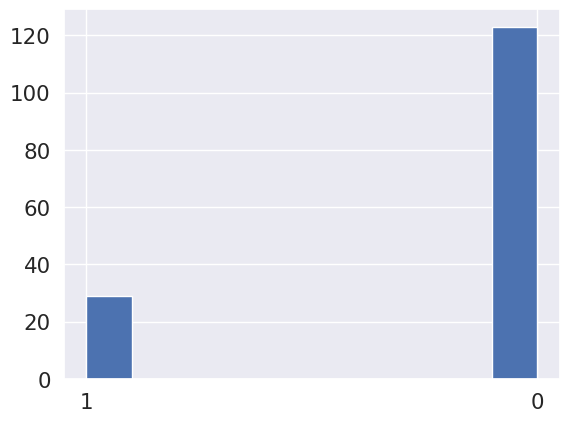

In [36]:
label_set['Binary Class'].hist()

In [37]:
# Model parameters
BATCH_SIZE = 16
EPOCHS = 50
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = 2
ES_PATIENCE = 10
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [38]:
def load_ben_color(image):
    IMG_SIZE = 320
    sigmaX=10
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted (image, 4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    # Convert to grayscale
    # image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image

In [39]:
from PIL import Image
im = Image.open("./input/dr-images/" + label_set.iloc[0].image_name)
im = np.array(im.resize((320, )*2, resample=Image.LANCZOS))

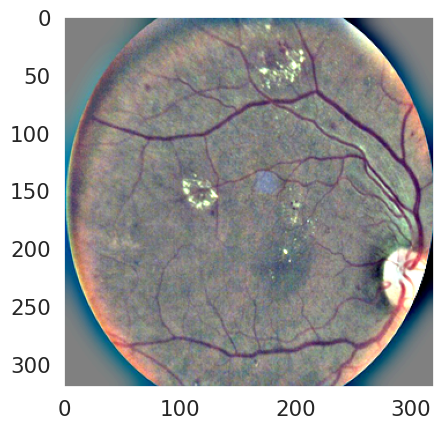

In [40]:
import matplotlib.pyplot as plt
plt.imshow(load_ben_color((im)))

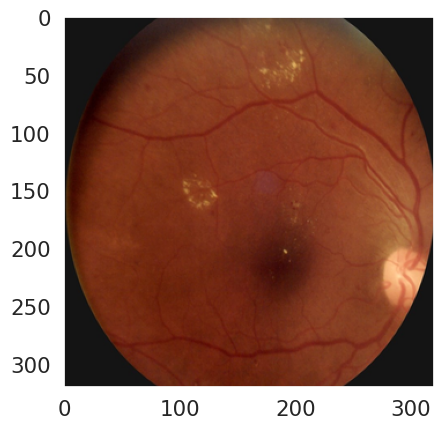

In [41]:
plt.imshow((im))

In [42]:
def img_generator(train):
    data_gen = ImageDataGenerator(rescale=1/255.,
                              zoom_range=0.2, # 0.15
                              fill_mode='constant',
                              cval=0.,
                              horizontal_flip=True,
                              brightness_range=[0.8, 1.2],  # Randomize brightness
                              preprocessing_function=load_ben_color)
    
    new_generator=data_gen.flow_from_dataframe(dataframe=label_set,
                                                      directory="./input/dr-images/",
                                                      x_col="image_name",
                                                      batch_size=2,
                                                      class_mode=None,
                                                      target_size=(HEIGHT, WIDTH),
                                              shuffle=False)
    
   
    
    
    return new_generator

In [43]:
new_generator = img_generator(label_set)

Found 152 validated image filenames.


In [44]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model, load_model
from keras.layers import BatchNormalization

In [45]:
# model = load_model("./models/desnet_final_model.h5") # , custom_objects={'encoding': 'utf-8'})
model = load_model("./models/resnet50_final_model.h5")
# 

In [46]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 320, 320, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 10, 10, 2048)         2358771   ['input_1[0][0]']             
                                                          2                                       
                                                                                                  
 batch_normalization (Batch  (None, 10, 10, 2048)         8192      ['resnet50[0][0]']            
 Normalization)                                                                                   
                                                                                              

In [47]:
label_step_size = new_generator.n//new_generator.batch_size
label_preds = model.predict_generator(new_generator, steps=label_step_size, verbose = 1)


/tmp/ipykernel_792884/2651199774.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  label_preds = model.predict_generator(new_generator, steps=label_step_size, verbose = 1)


76/76 [==============================] - 95s 1s/step


In [48]:
label_preds

array([[0.01320228, 0.9151053 ],
       [0.07976017, 0.9138679 ],
       [0.23205076, 0.68978494],
       [0.81439817, 0.2290331 ],
       [0.02261139, 0.8984183 ],
       [0.7926909 , 0.21924739],
       [0.9229636 , 0.10717484],
       [0.78397673, 0.24501877],
       [0.90641934, 0.09833449],
       [0.89625335, 0.10938581],
       [0.39448997, 0.6933832 ],
       [0.8608099 , 0.15313694],
       [0.8880826 , 0.13000053],
       [0.9292425 , 0.08001005],
       [0.82425743, 0.22049099],
       [0.85624784, 0.23873776],
       [0.82684964, 0.224746  ],
       [0.55163604, 0.6691612 ],
       [0.90934664, 0.08902342],
       [0.89833015, 0.11460304],
       [0.74173063, 0.36605242],
       [0.6824385 , 0.5816074 ],
       [0.83417284, 0.15118536],
       [0.8501503 , 0.20660071],
       [0.8398257 , 0.1940992 ],
       [0.8212268 , 0.22696094],
       [0.65700185, 0.5240488 ],
       [0.91855216, 0.08262245],
       [0.8515773 , 0.1733722 ],
       [0.7971628 , 0.23521864],
       [0.

In [49]:
predicted_labels = [np.argmax(pred) for pred in label_preds]

In [50]:
# model.predict_proba

In [51]:
def plot_conf_matrix(true,pred,classes):
    
    cf = confusion_matrix(true, pred)
    
    df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
    plt.figure(figsize=(8,5.5))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels = classes ,yticklabels = classes,fmt='g')
    plt.show()
    

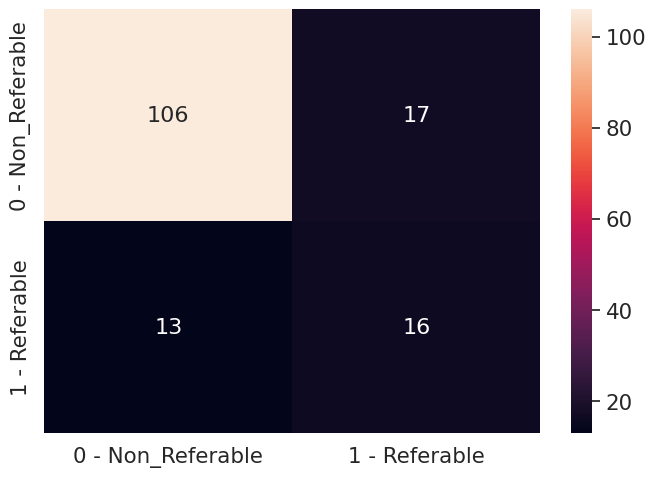

In [52]:
labels = ['0 - Non_Referable', '1 - Referable']
plot_conf_matrix(list(label_set['Binary Class'].astype(int)),predicted_labels,labels)

In [53]:
# print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(predicted_labels, label_set['Binary Class'].astype('int'), weights='quadratic'))
# print("Test Accuracy score : %.3f" % accuracy_score(label_set['Binary Class'].astype('int'), predicted_labels))

In [54]:
from sklearn.metrics import auc, precision_recall_fscore_support, roc_curve

def evaluate_model(y_test, y_pred) -> pd.DataFrame:
    """
    Evaluate Model and return results as a dictionary
    """

    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    _auc = auc(fpr, tpr)
    conf_matrix = confusion_matrix(y_test, y_pred)
    cohen_kappa = cohen_kappa_score(y_test, y_pred, weights='quadratic')
    tn, fp, fn, tp = conf_matrix.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    results = pd.DataFrame({
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1-Score': [f1_score],
        'AUC': [_auc],
        'Sensitivity': [sensitivity],
        'Specificity': [specificity],
        'Cohen Kappa Score': [cohen_kappa],
        'Confusion Matrix': [conf_matrix],
    })

    return results


In [55]:
evaluate_model(label_set['Binary Class'].astype('int'), predicted_labels)

,Accuracy,Precision,Recall,F1-Score,AUC,Sensitivity,Specificity,Cohen Kappa Score,Confusion Matrix
0,0.802632,0.813313,0.802632,0.807367,0.706756,0.551724,0.861789,0.39281,"[[106, 17], [13, 16]]"


In [56]:
# from sklearn.metrics import auc, precision_recall_fscore_support, roc_curve

# def evaluate_model(model, y_pred, y_test) -> list:
#       """
#         Evaluate Model
#       """
#       # ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC', 'Sensitivity', 'Specificity', 'Confusion Matrix']
#     #   y_pred = model.predict(X_test)
#       #
#       accuracy = accuracy_score(y_test, y_pred, average='weighted')
#       test_precision_recall_fscore_support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
#       #
#       fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
#       test_auc = auc(fpr, tpr)
#       # calculate the confusion matrix
#       conf_matrix = confusion_matrix(y_test, y_pred)
#       tn, fp, fn, tp = conf_matrix.ravel()
#       # calculate sensitivity (true positive rate)
#       sensitivity = tp / (tp + fn)
#       # calculate specificity (true negative rate)
#       specificity = tn / (tn + fp)

#       return [accuracy, test_precision_recall_fscore_support[0], test_precision_recall_fscore_support[1], test_precision_recall_fscore_support[2], test_auc, sensitivity, specificity, conf_matrix]
